<h1 align="center">Programming for Business Analytics</h1> 
<h2 align="center"> COMPGC27/MSING055</h2> 
<h2 align="center"> Group Coursework, Milestone 2</h2>

<h3 align="center">Team 14</h3>


| Member                | Email                         |
|:----------------------|:------------------------------|
|   Katerina Klimova      | ucabkkl@ucl.ac.uk             |
|   Lu Wang               | ucabwl0@ucl.ac.uk             |
|   Mesut Can Alkan       | mesut.alkan.16@ucl.ac.uk      |
|   Alexandros Baltas     | alexandros.baltas.16@ucl.ac.uk|
|   Dimitri Visnadi       | dimitri.visnadi.16@ucl.ac.uk  |


<h4 align="center">**Date:** December 1st, 2016</h4>



### Abstract

A Videogame company is about to expand into a new market. We have a dataset at hand that reviews games, platforms, publishers and genres. We will use this data in order to help the company design their strategy for expansion. We start of with some exploratory analysis so we can then design two different models that will help the company idenify in which platform and genre they should expand to.

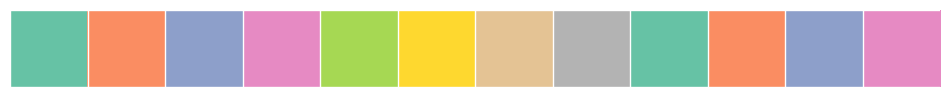

In [1]:
# Import packages 
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib 

sns.set_palette("Set2", 12)
sns.palplot(sns.color_palette())
sns.set_context('talk')

## The CoNVO:
In order to better understand the scope of this project, we briefly guide you through the four parts.
### Business Context: 
Our client is a video game company that produces games for PC. The company has a dataset of competitors’ game reviews at their disposal. This dataset includes reviews of games published for various platforms, the genre, and release dates.
### Needs: 
The company is planning to expand their business to other platforms as well. As they have never expanded to any other platform before, they highly rely on our analysis that will help form their expansion strategy. Their lack of experience is leaving them with a major open questions: Which platform market should they penetrate?
### Vision:
The marketing department will receive a report including the popularity of the gaming platforms over the years and a concluding recommendation which is the most promissing market for them.
### Mockup
A gaming company that has only established its marketshare amongst PC games, we can see an opportunity producing games for iOS market. The most promissing genre in this market over the next comming years seems to be action games.

### Import publishers

The original dataset did not have the publisher for each game. The Python code below was used to retrieve the publishers from the website:

In [2]:
import requests
import csv
from html.parser import HTMLParser

class PublisherParser(HTMLParser):

    def __init__(self):
        HTMLParser.__init__(self)
        self.getting_there = False
        self._publisher = None

    def get_publisher(self):
        return self._publisher

    def feed(self, data):
        self.getting_there = False
        self._publisher = None
        HTMLParser.feed(self, data)

    def handle_data(self, data):

        data = data.strip()
        if data == "Publisher":
            self.getting_there = True
        elif data != ":" and self.getting_there:
            self._publisher = data
            self.getting_there = False

class UrlRetriever(object):

    def __init__(self, base):
        self._base_url = base

    def get_base_url(self):
        return self._base_url

    def retrieve(self, url):
        return requests.get(self.get_base_url() + url).text

# --- Uncomment to repeat the process ---
# retriever = UrlRetriever("http://uk.ign.com")
# parser = PublisherParser()

# with open("../data/ign.csv") as f:
#     reader = csv.reader(f, delimiter=',')
#     for row in reader:
#         if row[3] == "url":
#             row.append("Publisher")
#             with open("../data/ign_with_publishers.csv", "w") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)
#         else:
#             parser.feed(retriever.retrieve(row[3]))
#             row.append(parser.get_publisher())
#             with open("../data/ign_with_publishers.csv", "a") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)

## Data Overview
We first have a look at the structure of the data to get an idea. We can see that some values for the column "genre" is missing. In addition, the column "Publisher" is also missing some values, but we can confirm that there was no such information displayed on the website.

In [3]:
# Load data into a data frame using pandas
games_df = pd.read_csv("data/ign_with_publishers.csv")
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18625 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        18625 non-null int64
score_phrase      18625 non-null object
title             18625 non-null object
url               18625 non-null object
platform          18625 non-null object
score             18625 non-null float64
genre             18589 non-null object
editors_choice    18625 non-null object
release_year      18625 non-null int64
release_month     18625 non-null int64
release_day       18625 non-null int64
Publisher         17720 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.7+ MB


## Data cleanup

### Missing values
As mentioned above, while compiling the data by bringing publisher names using url sources, there were still some missing values for publisher names and genre. As is difference was insignificant small (< 5%), we decided to discard the missing values.

In [4]:
games_df = games_df.dropna()
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17687 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        17687 non-null int64
score_phrase      17687 non-null object
title             17687 non-null object
url               17687 non-null object
platform          17687 non-null object
score             17687 non-null float64
genre             17687 non-null object
editors_choice    17687 non-null object
release_year      17687 non-null int64
release_month     17687 non-null int64
release_day       17687 non-null int64
Publisher         17687 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.8+ MB


## Exploratory anylsis
In order to get a better understanding of the data. We began with some exploratory anylsis to see the behavior of the review scores, the platform and the publishers.  

### Score Phrases

There are eleven different score phrases for the scores ranging from 0 to 10. Masterpiece being 10 was followed by Amazing, Great, Good, Okay, Mediocre, Bad, Awful, Painful, Unbearable, Disaster for each point range (e.g 9.0-9.9).

You can see from the table and the graph that the distribution is skewed to positive score phrases.


In [5]:
games_df.groupby('score_phrase').score.agg(['mean', 'count']).sort_values('mean')

,mean,count
score_phrase,,
Disaster,0.666667,3
Unbearable,1.272308,65
Painful,2.267485,326
Awful,3.287658,632
Bad,4.333223,1210
Mediocre,5.316865,1850
Okay,6.362283,2768
Good,7.369226,4520
Great,8.316648,4553


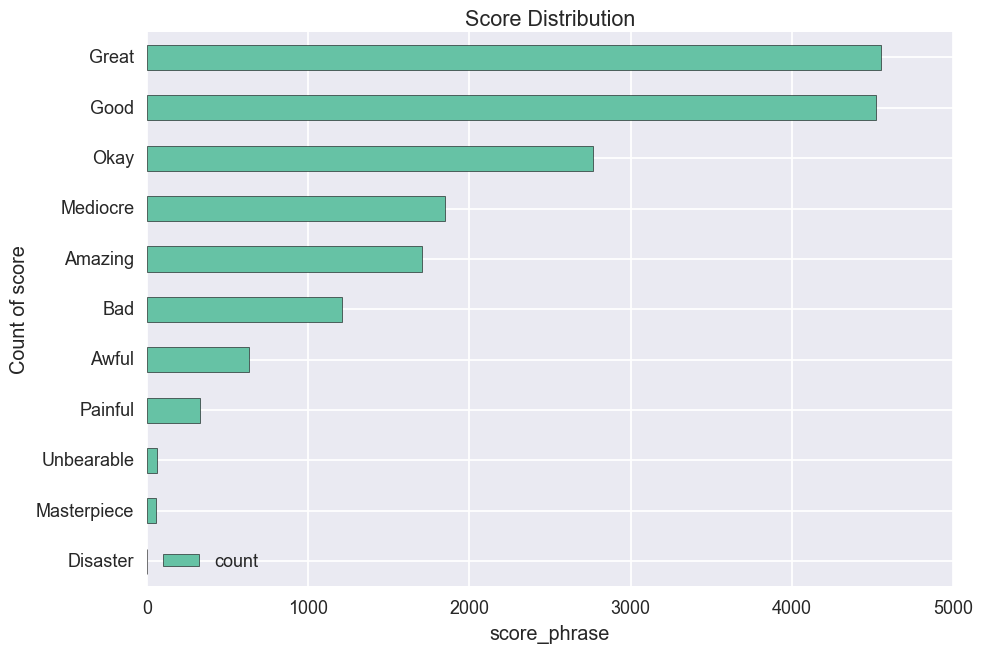

In [6]:
# Score Distribution plot
plt.figure(figsize=(8,4))
score_phrase_count = games_df.groupby('score_phrase').score.agg(['count'])
score_phrase_count = score_phrase_count.sort_values('count')
score_phrase_count.plot(kind='barh')
plt.xlabel("score_phrase")
plt.ylabel("Count of score")
plt.title("Score Distribution")

## Outlier
There was one game with the release year 1970 for the Xbox. As this is clearly a mistake we discarded that entry.

In [7]:
games_df = games_df[games_df.release_year > 1970]

### Platform names
Platform names slightly evolved for some categories over the historical period. Such as Play Station, then Play Station 2, Play Station 3, 4, Portable, Vita etc. Consequently, we have mapped again and unified these platform names. For instance, we used Nintendo for all nintendo-related platforms.
We have also unified all iPad, iPhone and iPod platform names as these look alike.

### Publisher names
As publisher names may include different company names under the same group, we followed the same methodology as the platform names. For example, Sierra, Sierra Attractions, Sierra On-Line, Sierra Sports, Sierra Studios were all unified due to being part of Sierra Entertainment. So, we applied the same rule to publisher names if they look alike.

In [8]:
games_df = games_df.replace(["Xbox 360", "Xbox One"], "Xbox")
games_df = games_df.replace(["PlayStation", "PlayStation 2", "PlayStation 3", "PlayStation 4","PlayStation Portable", "PlayStation Vita"], "PlayStation")
games_df = games_df.replace(["Nintendo 3DS","Nintendo 64","Nintendo 64DD","Nintendo DS","Nintendo DSi"], "Nintendo")
games_df = games_df.replace(["iPad","iPhone","iPod"], "iOS")
games_df = games_df.replace(["Game Boy","Game Boy Advance","Game Boy Color"], "Game Boy")
games_df = games_df.replace(["WonderSwan","WonderSwan Color"], "WonderSwan")
games_df = games_df.replace(["Wii", "Wii U"], "Wii")
games_df = games_df.replace(["TurboGrafx-16", "TurboGrafx-CD"], "TurboGrafx")
games_df = games_df.replace(["Sega 32X", "Sega CD"], "Sega")
games_df = games_df.replace(["NeoGeo", "NeoGeo Pocket Color"], "NeoGeo")
games_df = games_df.replace(["Dreamcast", "Dreamcast VMU"], "Dreamcast")
games_df = games_df.replace(["Atari 2600", "Atari 5200"], "Atari")


games_df = games_df.replace(["Sierra","Sierra Attractions","Sierra On-Line","Sierra Sports","Sierra Studios"], "Sierra")
games_df = games_df.replace(["Sony BMG Music Entertainment","Sony Computer Entertainment","Sony Online Entertainment","Sony Pictures Entertainment","Sony Pictures Mobile"], "Sony")
games_df = games_df.replace(["Atari","Atari Corp. (1984-2003)","Atari Games"], "Atari")
games_df = games_df.replace(["Namco","Namco Hometek","Namco Networks"], "Namco")
games_df = games_df.replace(["SNK","SNK NeoGeo","SNK Playmore"], "SNK")
games_df = games_df.replace(["Square Enix","Square Enix Collective","Square Enix Mobile"], "Square Enix")
games_df = games_df.replace(["11 Bit Studio","11 Bit Studios"], "11 Bit Studio")
games_df = games_df.replace(["Bandai","Bandai Namco Games"], "Bandai")
games_df = games_df.replace(["Capcom","Capcom Mobile"], "Capcom")
games_df = games_df.replace(["Commodore","Commodore Gaming"], "Commodore")
games_df = games_df.replace(["HeadGames","HeadGames Publishing"], "HeadGames")
games_df = games_df.replace(["Humongous","Humongous Entertainment"], "Humongous")
games_df = games_df.replace(["Intense","Intense Games"], "Intense")
games_df = games_df.replace(["LEGO Interactive","LEGO Media"], "LEGO")
games_df = games_df.replace(["SEGA","SEGA Mobile"], "SEGA")
games_df = games_df.replace(["THQ","THQ Wireless"], "THQ")


### Data Analysis & Visualization

Following the structuring and mapping process, we visualized the data with the number of the games in different platforms over the historical period. 

* Most successful platforms over last decade: PlayStation, PC, Xbox, Nintendo, Wii, and iOS
* Out of life: Wireless, GameCube, Dreamcast, Game Boy
* Long performer: PlayStation, PC, Xbox



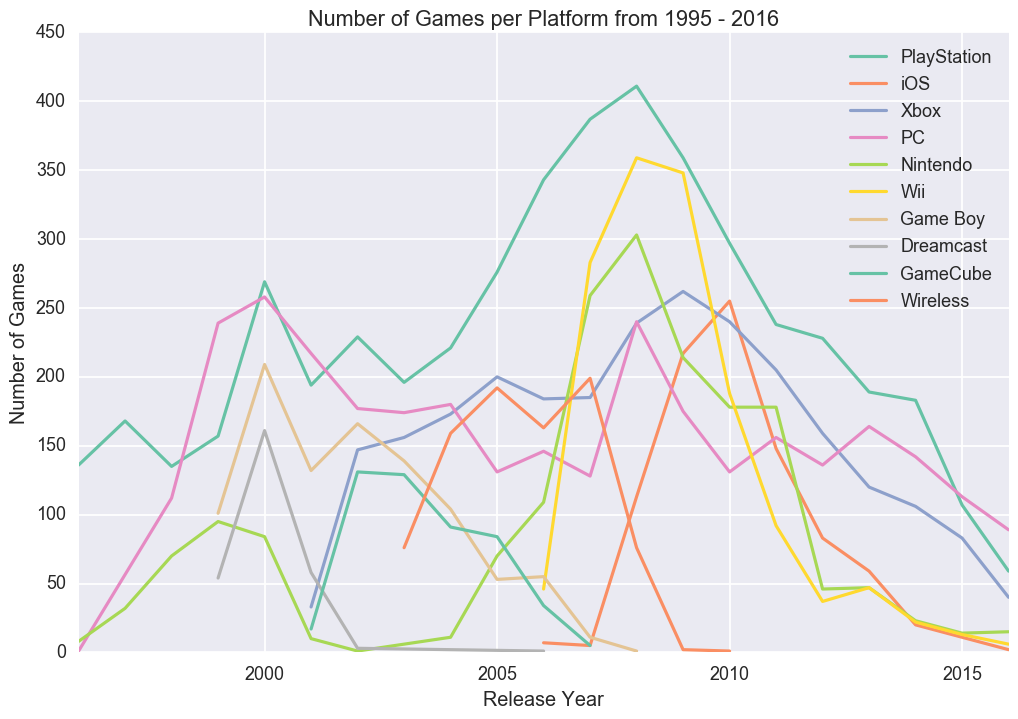

In [9]:
# Number of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
labels = []
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        labels.append(platform)
        ax = games_df[games_df.platform == platform].groupby(['release_year']).size().plot()
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games per Platform from 1995 - 2016")

## The Big Players
The top publisher by far is Electronic Arts, followed by Ubisoft, Activision, and Nintendo. We can see that the majority of published games are produced by the top 10 companies. Besides the Top 10 gameproducers, we can say that the industry seems to be widley scattered with a large number of smaller incumbents. 

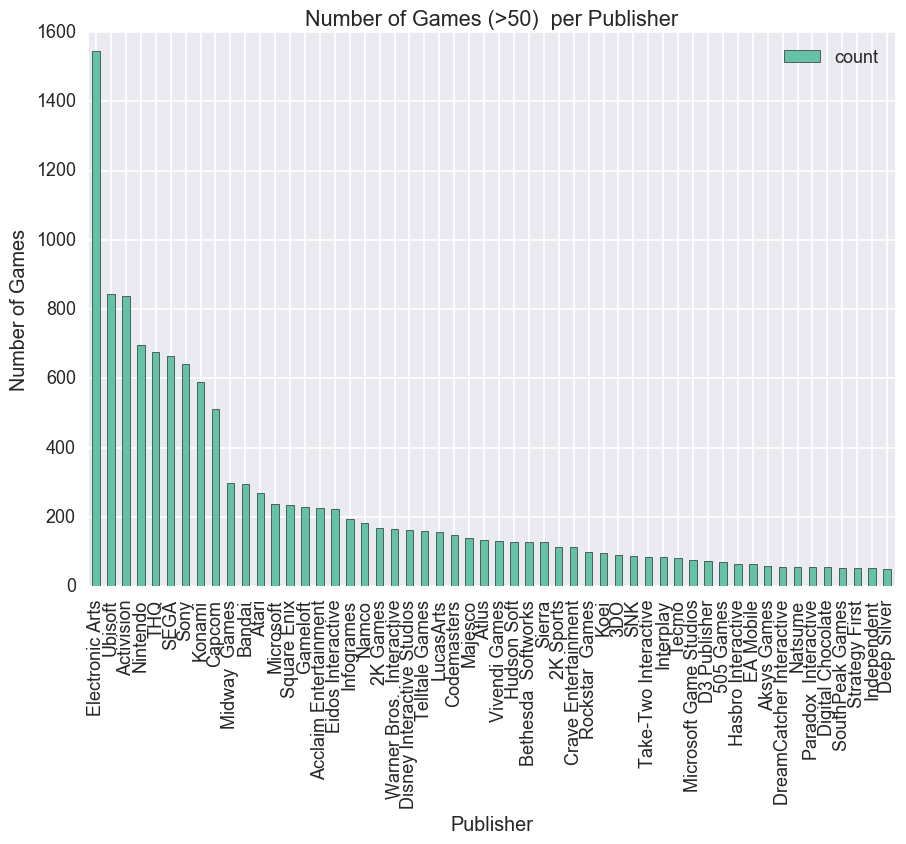

In [10]:
# Number of Games (>50)  per Publisher
plt.figure(figsize=(12,8))
publisher_numbers=games_df.groupby('Publisher').score.agg(['count'])
publisher_numbers=publisher_numbers[publisher_numbers['count']>50].sort_values('count',ascending=False)
publisher_numbers.plot(kind='bar',stacked=True)
plt.xlabel("Publisher")
plt.ylabel("Number of Games")
plt.title("Number of Games (>50)  per Publisher")

### Publishers
We compute and display the average score per publishers. You can see a tendency that some companies' games are btter reviewed than others.

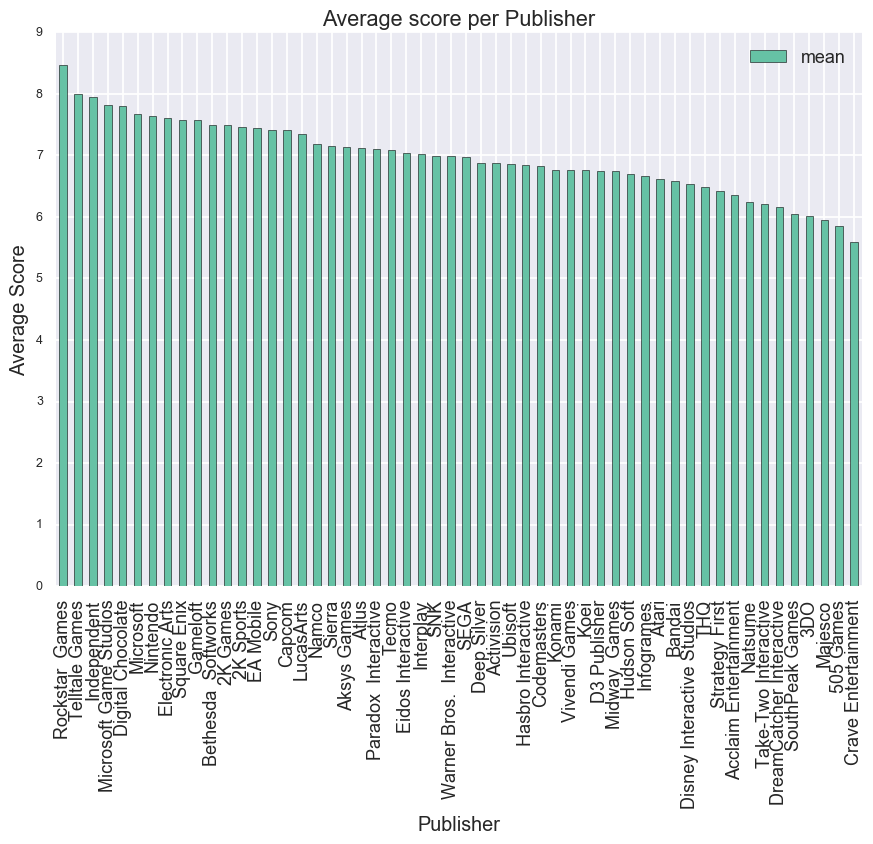

In [23]:
# Average score per Publisher
plt.figure(figsize=(12,8))
publisher_scores=games_df.groupby('Publisher').score.agg(['mean','count'])
publisher_scores=publisher_scores[publisher_scores['count']>50].sort_values('mean',ascending=False)
publisher_scores = publisher_scores.drop('count', 1)
publisher_scores.plot(kind='bar',stacked=True)
plt.xlabel("Publisher")
plt.ylabel("Average Score")
plt.title("Average score per Publisher")

## Genre
Looking at the genre we can definetly see a trend that some categories of games are more popular than others.

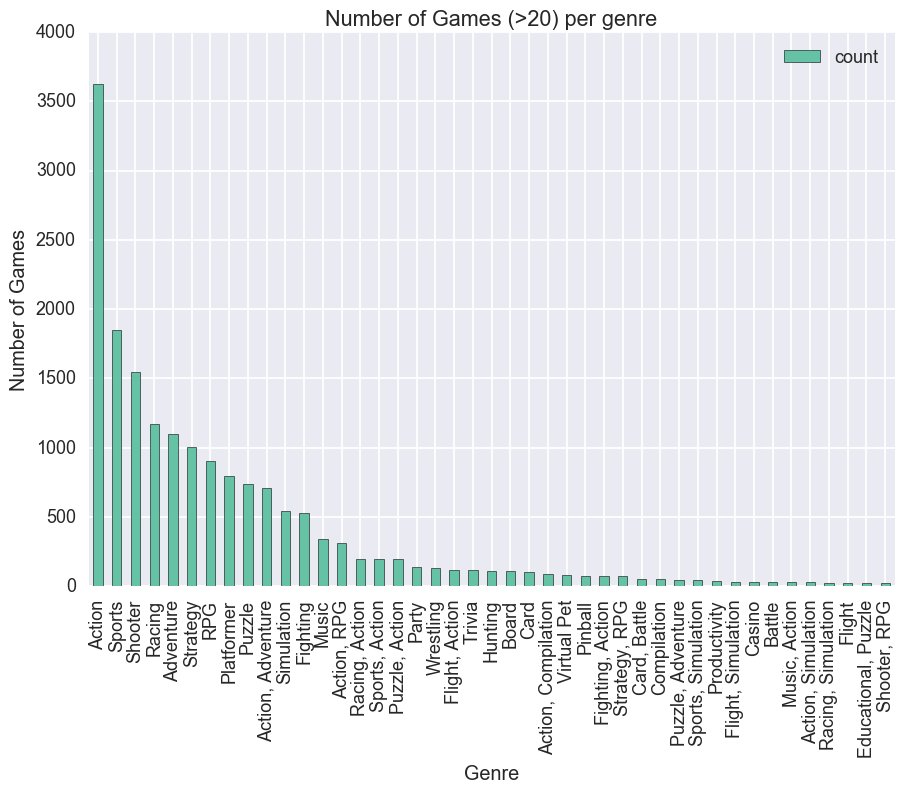

In [12]:
# plot genre--numbers of games
plt.figure(figsize=(12,8))
genre_numbers=games_df.groupby('genre').score.agg(['count'])
genre_numbers=genre_numbers[genre_numbers['count']>20].sort_values('count',ascending=False)
genre_numbers.plot(kind='bar',stacked=True)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Number of Games (>20) per genre")

Generally, the ratings amongst different platforms seems to be consistent. This leads to the hypothesis that the success is less depending on the platform but more on the genre.

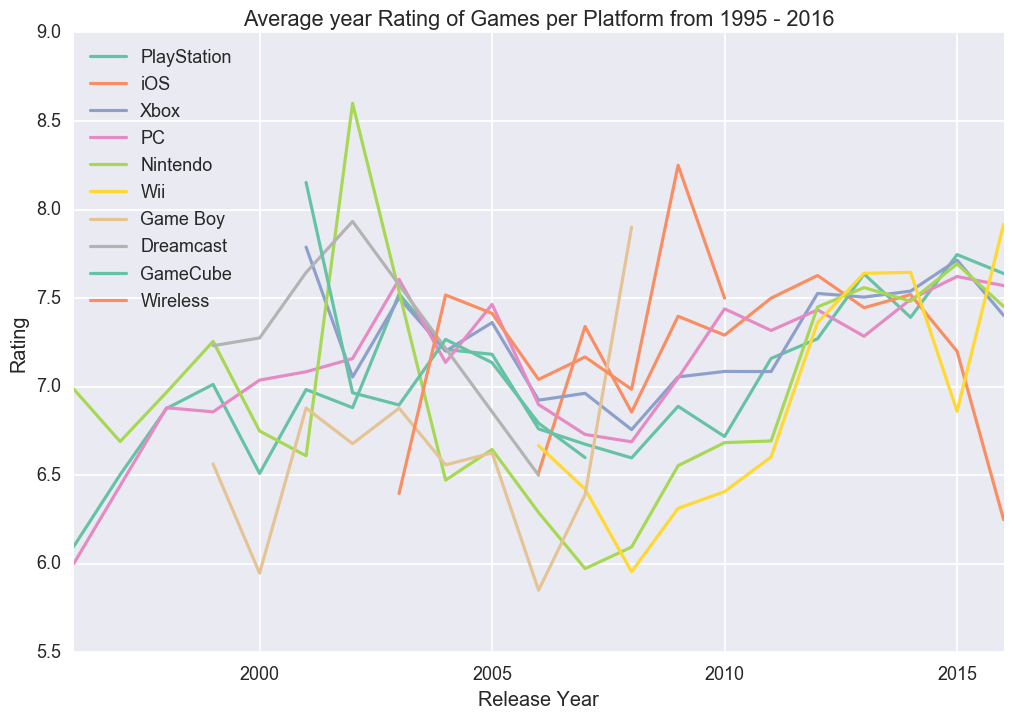

In [13]:
# Average year Rating of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
labels=[]
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        ax = games_df[games_df.platform == platform].groupby(['release_year']).score.mean().plot()
        labels.append(platform)
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

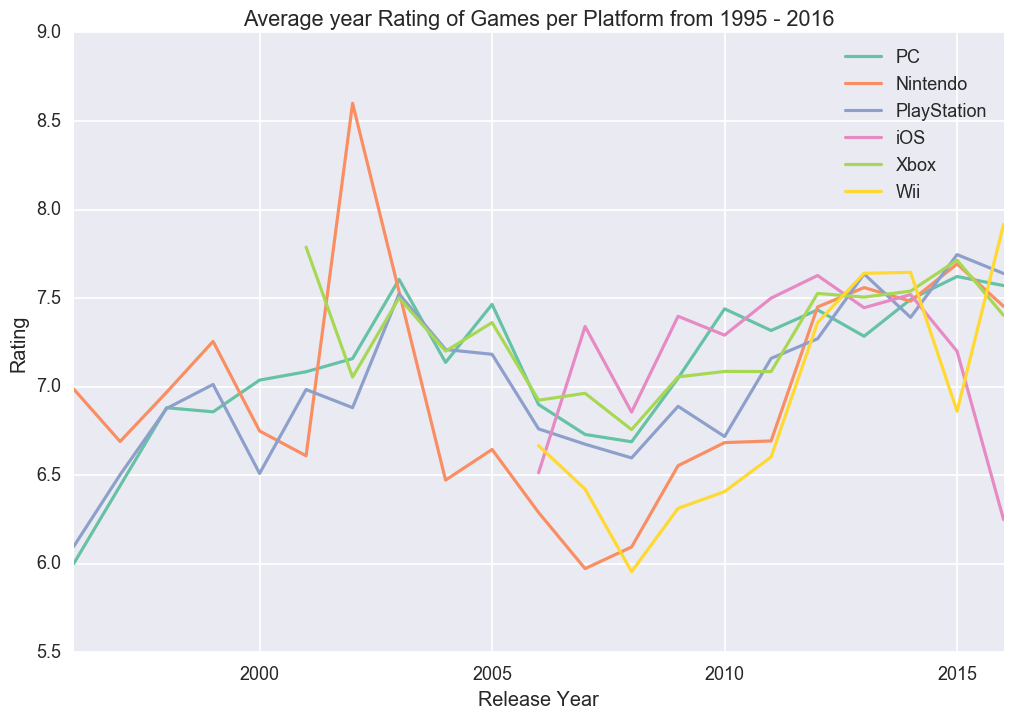

In [14]:
# Average year Rating of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
platfroms_list = ["PC", "Nintendo", "PlayStation", "iOS", "Xbox", "Wii"]
for p in platfroms_list:  
    ax = games_df[games_df.platform == p].groupby(['release_year']).score.mean().plot()
ax.legend(platfroms_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

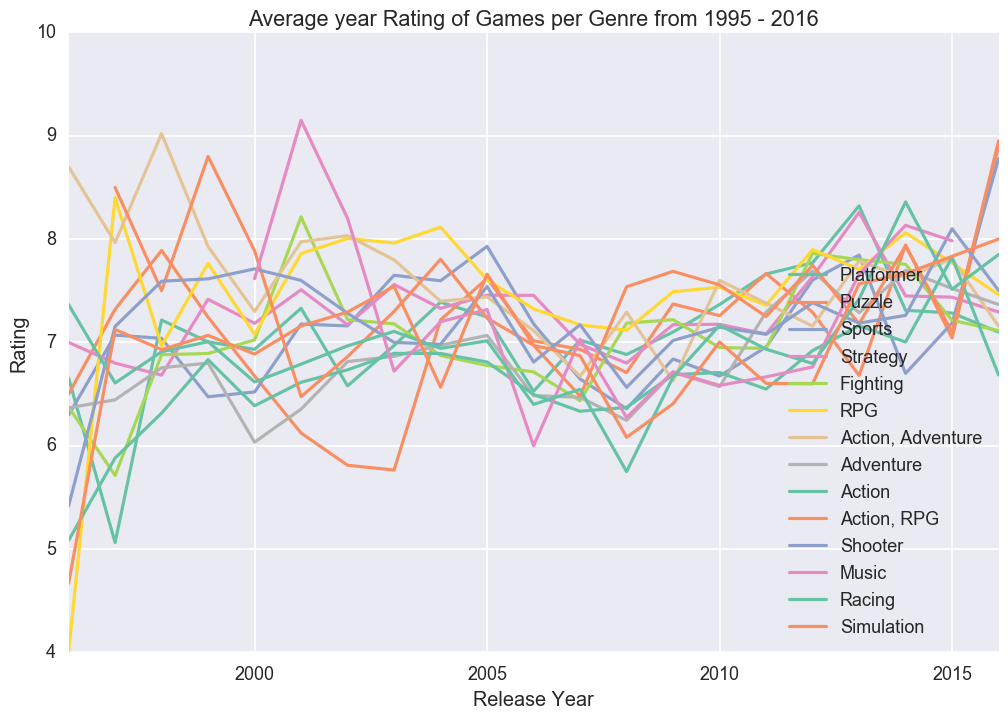

In [15]:
# Average year Rating of Games per Genre from 1995 - 2016
plt.figure(figsize=(12,8))
genres_list=[]
for genre in games_df.genre.unique():  
    temp = games_df[games_df.genre == genre]
    if temp.shape[0] > 200:
        ax = games_df[games_df.genre == genre].groupby(['release_year']).score.mean().plot()
        genres_list.append(genre)
ax.legend(genres_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Genre from 1995 - 2016")

## Platform vs Genre
Looking at the confusion matrix, it is easy to idenify how platforms were reviewed in different genres.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


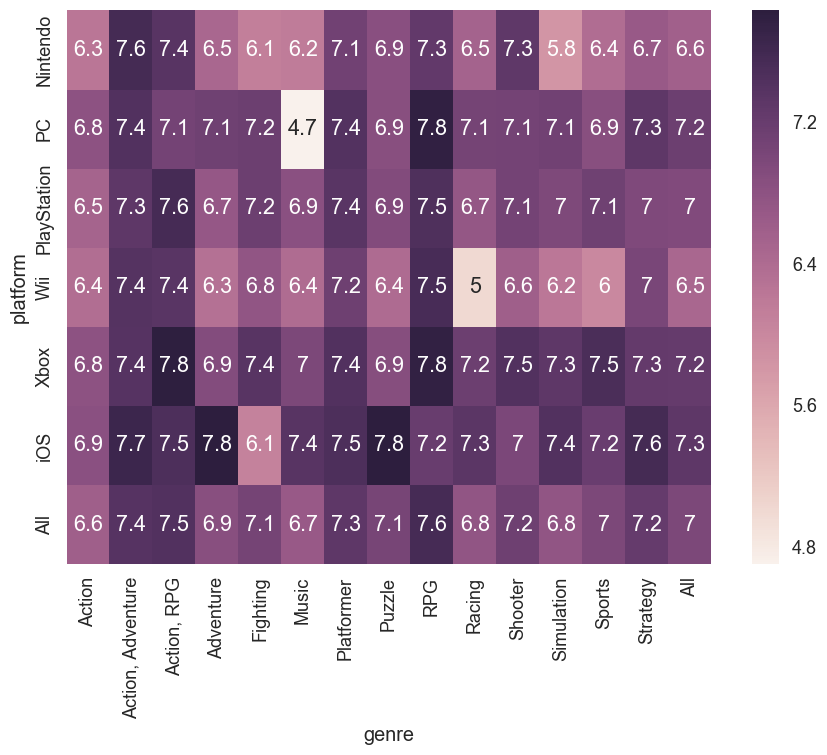

In [16]:
#  Confusuion matrix - Platform vs Genre
table_avg_score = pd.pivot_table(games_df[games_df.platform.isin(platfroms_list)][games_df.genre.isin(genres_list)]
                                 ,values=['score'],columns=['genre'],index=['platform'],aggfunc=np.average,margins=True)


ax=sns.heatmap(table_avg_score['score'], annot = True)

### Timeline graph of platfoms

Only a handfull of platforms are still releasing games.

In [17]:
# create new date column
games_df['Date'] = games_df.apply(lambda row: datetime(row['release_year'], row['release_month'], row['release_day']), axis=1)

In [18]:
# Filling up new dataframe for timeline 
df_timeline = pd.DataFrame(games_df['platform'])
df_timeline = df_timeline.drop_duplicates()
df_timeline = df_timeline.reset_index(drop=True)
games_df = games_df.reset_index(drop=True)

df_timeline['year_min'] = pd.to_datetime('2017-01-01 00:00')
df_timeline['year_max'] = pd.to_datetime('1950-01-01 00:00')

In [19]:
# New dataframe only including the first and last releast date for each platform
for i in range(len(df_timeline)):
    for j in range(len(games_df)):
        try:
            if df_timeline['platform'][i] == games_df['platform'][j] and df_timeline['year_min'][i] > games_df['Date'][j]: 
                df_timeline['year_min'][i] = games_df['Date'][j]
            
            if df_timeline['platform'][i] == games_df['platform'][j] and df_timeline['year_max'][i] < games_df['Date'][j]: 
                df_timeline['year_max'][i] = games_df['Date'][j]
        except:
            pass                       

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# List of platforms for plot
testNames = []
for i in df_timeline['platform']:
    testNames.append(i)

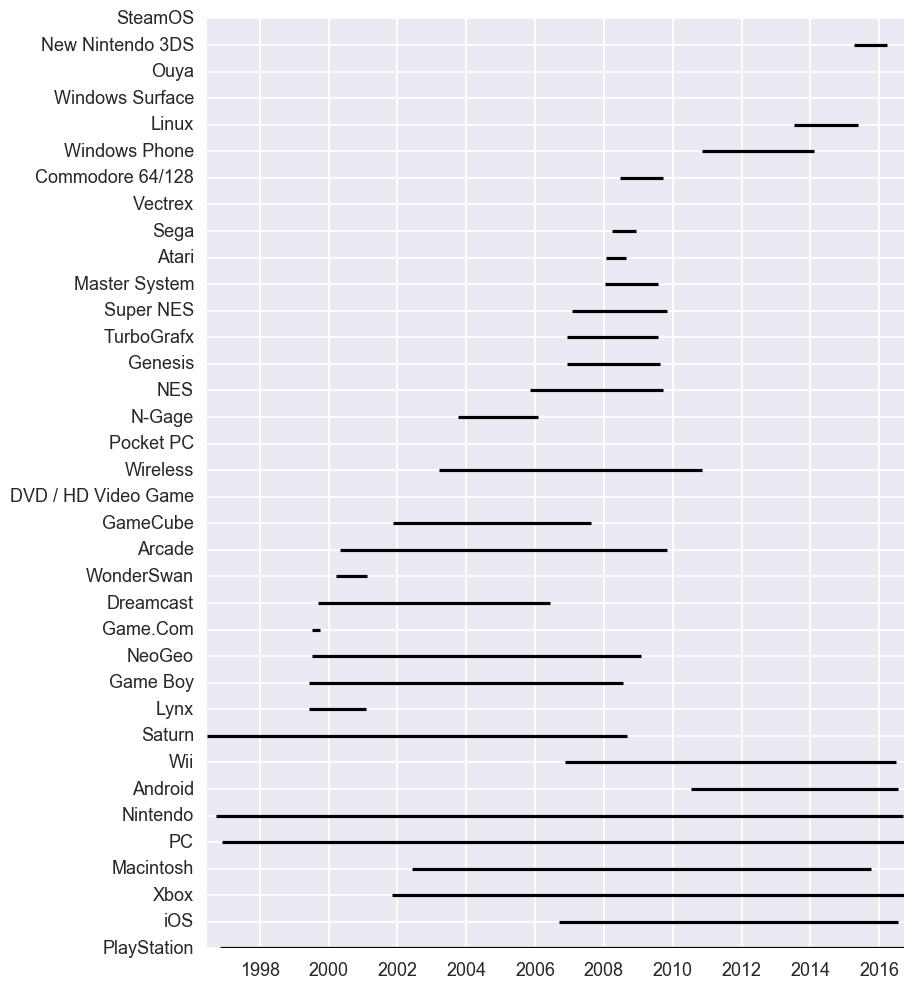

In [21]:
# Plotting timeline of platforms
df_timeline.amin = pd.to_datetime(df_timeline.year_min).astype(datetime)
df_timeline.amax = pd.to_datetime(df_timeline.year_max).astype(datetime)

fig = plt.figure(figsize = (9,12))
pos = np.arange(len(testNames))
plt.yticks(pos, testNames)
matplotlib.rc('ytick', labelsize=9) 
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df_timeline.index, dt.date2num(df_timeline.amin), dt.date2num(df_timeline.amax))

## Models

### Model: Classification

The task of identifying the attributes of a game in order for it to be successful, can be seen as a classification problem. For our analysis, we will try out different schemes of classification problems, to find out which performs best:

* Successful vs non-successful game: In this case, we are going to define a threshold θ in the games' score such as games with score s > θ are going to be classified as successful, and games with score s < θ will be classified as non-successful.
* Score phrase classification: Games are going to be classified into the 11 different score phrases which are explained above.
* Masterpiece identification: In this case, we will try to identify the features of the games that are scored with 10, and try to build a classifier that detects only the Masterpieces.

#### Features & Algorithms

Different classification problems may perform in different ways depending on the input features, and classification algorithm used. For our analysis, we will try to construct different features and identify which ones boost the performance of the classifiers (eg. Genre, Platform, Number Of Platforms). Moreover, we will use different classification algorithms such as Logistic Regression, Random Forests, SVM etc.

To tune the different models, and optimise the hyperparameters we can use different techniques, such as splitting the dataset into 3 segments -train, dev & test- and perform grid search over the hyperparameters, k-fold cross-validation etc. By using the *training set* to train, *dev test* to tune and *test set* to evaluate our models we can avoid overfitting.

#### Evaluation

The evaluation metrics that will be used will be different for each classification method. For example, in the *Masterpiece Identification* case, the Accuracy metric will be insufficient because the dataset is going to be unbalanced to a great degree. F1-Score, Precision, Recall and Confusion Matrices are going to be utilized for our evaluation.


### Model: Clustering

#### K-means clustering

We aim to use K-means clustering method to form clusters of a combination of different features of games (such as genres, platforms, publishers) belonging to same / similar scores.

##### K-means algorithm: 
First, we decide the number of clusters k. An empirical way to find the best number of clusters is to try K-means clustering with a different number of clusters and observe the results. The k-means algorithm starts with initialization function which assigns data points to the k clusters. Then the algorithm finds mean for each cluster. Once the means are updated, the algorithm associates points with the nearest mean. Algorithm repeats the mean updating part and data points reassigning part until it converges.

### Agglomerative clustering
We also aim to use agglomerative clustering on a combination of different features of games (such as genres, platforms, publishers) belonging to scores and to summarise the process by a hierarchical tree.

##### Agglomerative clustering algorithm
In the agglomerative hierarchical approach, we start by defining each data point to be a cluster and combine existing clusters at each step. After we try the methods of single linkage, complete linkage, average linkage, centroid method, we will compare the results form an overall judgment about the final formation of clusters. 